In [20]:
from astropy import units as u
from astropy.time import TimeDelta

from poliastro.util import Time
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator
from poliastro.core.propagation import func_twobody
from poliastro.core.perturbations import J2_perturbation

from perturbations import coesa76_model


from inc_from_smaecc import required_inc
#from raan_from_epoch import raan_from_epoch

import numpy as np
import time

from poliastro.plotting import OrbitPlotter3D
from matplotlib import pyplot as plt

# 3 planes, 90 satellite, wd: i:90/3/5, 380km SSO 

process_start_time = time.time()   # start time (instant) of python code
start_date_time = time.ctime()  # start time (clock) of python code
print(f'\n--- WALKER DELTA CONSTELLATION --- [process start: {start_date_time}]\n')

# Constants
R = (Earth.R).to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value
J2 = Earth.J2.value

# Orbital inputs
alt = 380 * u.km
a   = R*u.km + alt
ecc = 0.001 * u.one
inc = required_inc(a.value, ecc.value) * u.deg
argp = 0 * u.deg

start_date = Time("2023-01-01 12:00:00.000", scale = "utc")
#raan_0 = raan_from_epoch(10, start_date)

# Satellite parameters
C_D = 2.2
A_over_m = ((0.01 * u.m**2) / (2.5 * u.kg)).to_value(u.km**2 / u.kg)   # km**2/kg

# Propagation time parameters
time_frame = 7 * u.day   #float(input('Time frame [days]: ')) * u.day
time_step  = 3600 * u.s #float(input('Time step [sec]: ')) * u.s

number = int(time_frame.to_value(u.s) / time_step.value)
tofs = TimeDelta(np.linspace(0, time_frame, num=number))

# sensor parameters
sw = 50 * 0.5 # [km]


--- WALKER DELTA CONSTELLATION --- [process start: Mon Dec 18 16:12:07 2023]



In [22]:
# Perturbations
def a_d(t0, state, k, J2, R, C_D, A_over_m):

        return J2_perturbation(
        t0, state, k, J2, R
        ) + coesa76_model(
            state, R, C_D, A_over_m
        )
        
def f_pert(t0, state, k):
        
        du_kep = func_twobody(t0, state, k)
        ax, ay, az = a_d(
            t0, 
            state, 
            k=k, 
            J2 = J2, 
            R = R, 
            C_D = C_D, 
            A_over_m = A_over_m
            )
        du_ad = np.array([0, 0, 0, ax, ay, az])

        return du_kep + du_ad


In [23]:
# Walker Delta pattern --> inc:t/p/f
t = 90     # total number of satellites
p = 3      # orbital planes
f = 0.75   # phasing parameter
delta_nu = f * 360 / t 
s = int(t/p)   # satellites per orbit

sats_orbit_list = []
for plane in range(p):
    raan = (plane * 360 /p) * u.deg

    for sat in range(s):
        nu = (sat*360/s + delta_nu*plane) * u.deg
        orbit_0 = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, start_date)
        ephem = orbit_0.to_ephem(EpochsArray(start_date + tofs, method=CowellPropagator(rtol=1e-5, f=f_pert)))
        sats_orbit_list.append(ephem)


C:\Users\loren\AppData\Roaming\Python\Python310\site-packages\astropy\units\decorators.py:313: UserWarning:

Wrapping true anomaly to -π <= nu < π



In [24]:
a_list     = []
ecc_list   = []
inc_list   = []
raan_list  = []
argp_list  = []
nu_list    = []
epoch_list = []

for epoch in range(len(tofs)):
    
    a_list.append(Orbit.from_ephem(Earth, sats_orbit_list[0], sats_orbit_list[0].epochs[epoch]).a.value)
    ecc_list.append(Orbit.from_ephem(Earth, sats_orbit_list[0], sats_orbit_list[0].epochs[epoch]).ecc.value)
    inc_list.append(Orbit.from_ephem(Earth, sats_orbit_list[0], sats_orbit_list[0].epochs[epoch]).inc.to_value(u.deg))
    raan_list.append(Orbit.from_ephem(Earth, sats_orbit_list[0], sats_orbit_list[0].epochs[epoch]).raan.to_value(u.deg))
    argp_list.append(Orbit.from_ephem(Earth, sats_orbit_list[0], sats_orbit_list[0].epochs[epoch]).argp.to_value(u.deg))
    nu_list.append(Orbit.from_ephem(Earth, sats_orbit_list[0], sats_orbit_list[0].epochs[epoch]).nu.to_value(u.deg))
    epoch_list.append(Orbit.from_ephem(Earth, sats_orbit_list[0], sats_orbit_list[0].epochs[epoch]).epoch.value)

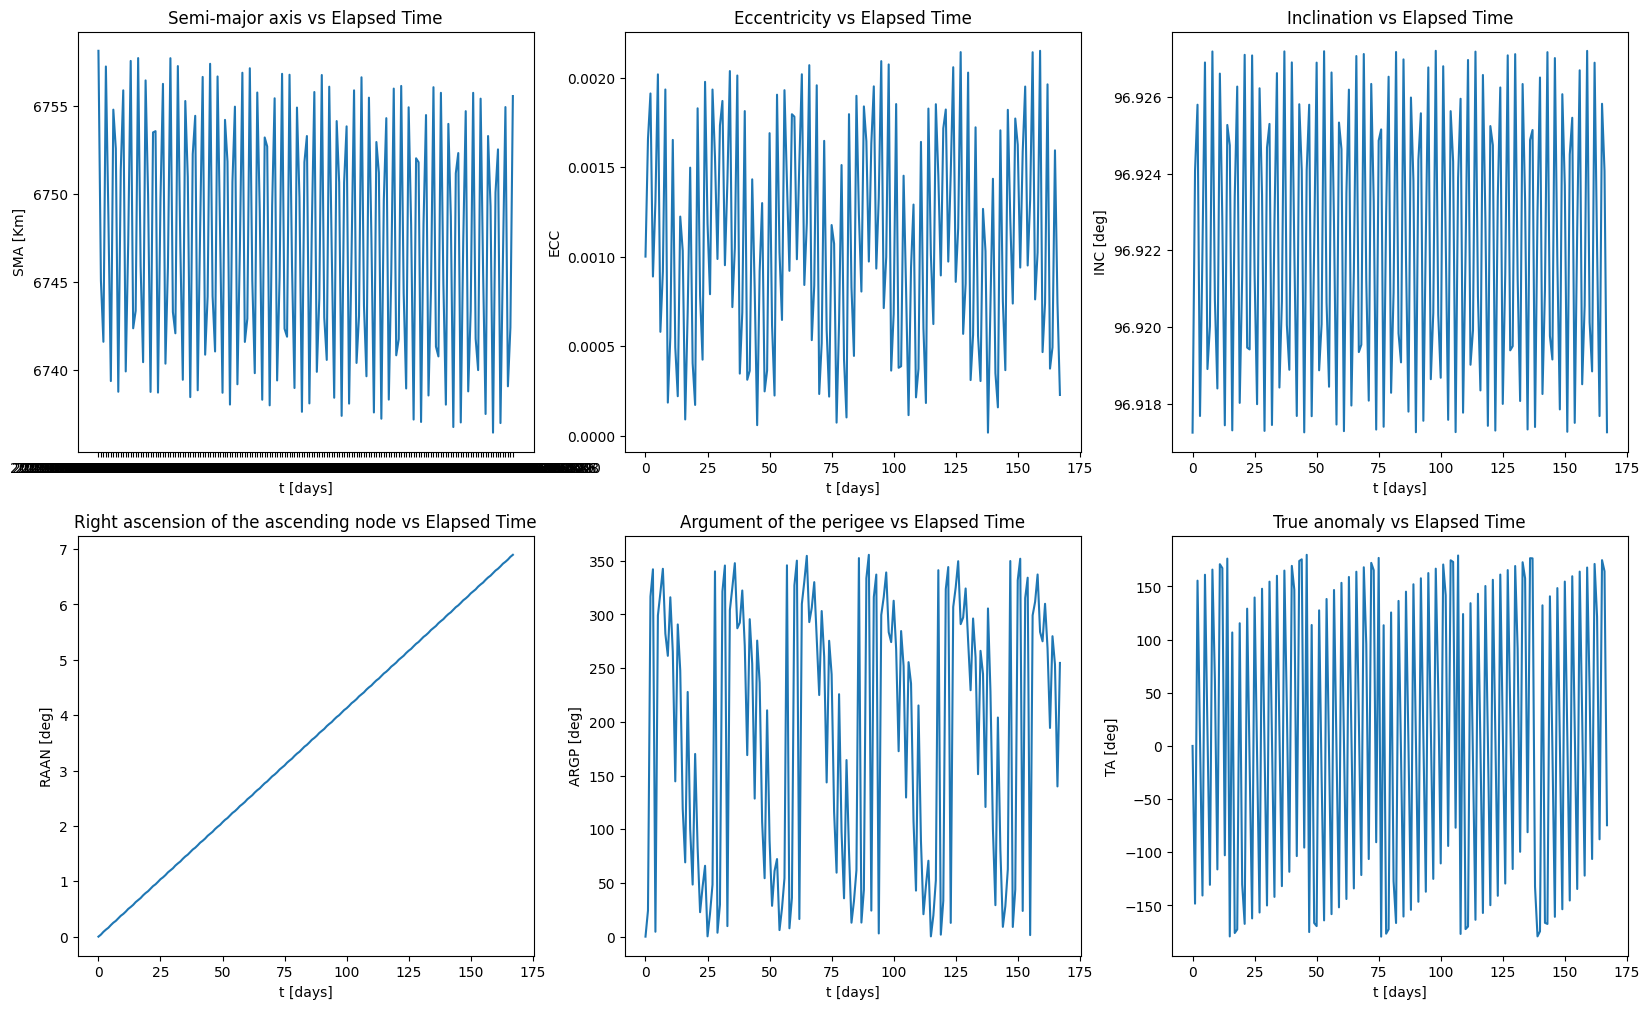

In [25]:
fig, ax = plt.subplots(2,3, figsize=(20,12))
ax[0,0].plot(epoch_list, a_list)
ax[0,0].set(title = "Semi-major axis vs Elapsed Time",
       xlabel = "t [days]",
       ylabel = "SMA [Km]")

ax[0,1].plot(range(len(a_list)), ecc_list)
ax[0,1].set(title = "Eccentricity vs Elapsed Time",
       xlabel = "t [days]",
       ylabel = "ECC")

ax[0,2].plot(range(len(a_list)), inc_list)
ax[0,2].set(title = "Inclination vs Elapsed Time",
       xlabel = "t [days]",
       ylabel = "INC [deg]")

ax[1,0].plot(range(len(a_list)), raan_list)
ax[1,0].set(title = "Right ascension of the ascending node vs Elapsed Time",
       xlabel = "t [days]",
       ylabel = "RAAN [deg]")

ax[1,1].plot(range(len(a_list)), argp_list)
ax[1,1].set(title = "Argument of the perigee vs Elapsed Time",
       xlabel = "t [days]",
       ylabel = "ARGP [deg]")

ax[1,2].plot(range(len(a_list)), nu_list)
ax[1,2].set(title = "True anomaly vs Elapsed Time",
       xlabel = "t [days]",
       ylabel = "TA [deg]")

plt.show()